In [1]:
%load_ext cudf.pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import zipfile

In [2]:
pd

<module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>

### variables

In [11]:
total = {}
totales_mexico = { f"edo-{i}"for i in range(0, 32)}
total["fecha"] = []
total["poblacion"] = []
total["Edad0-15"] = []
total["Edad16-30"] = []
total["Edad31-45"] = []
total["Edad46-60"] = []
total["Edad61-75"] = []
total["Edad76-90"] = []
total["Edad91-105"] = []
total["hombres"] = []
total["mujeres"] = []
#total["no_especificado"] = []
total["negativos"] = []
total["positivos"] = []
total["sospechosos"] = []
total["defunciones"] = []
#total["recuperados"] = []
#total["activos"] = []
total["hospitalizados"] = []
total["ambulatorios"] = []
total["hospitalizados_en_uci"] = []
total["hospitalizados_no_uci"] = []
#total["ENTIDAD_RES"] = []# 32 estados
#total["MUNICIPIO_RES"] = []
#total["ENTIDAD_UM"] = []
#total["ENTIDAD_NAC"] = []
total["EMBARAZO"] = []  
total["INTUBADO"] = []
total["NEUMONIA"] = []
total["DIABETES"] = []
total["EPOC"] = []
total["ASMA"] = []
total["INMUSUPR"] = []
total["HIPERTENSION"] = []
total["OTRA_COM"] = []
total["CARDIOVASCULAR"] = []
total["OBESIDAD"] = []
total["RENAL_CRONICA"] = []
total["TABAQUISMO"] = []
total["OTRO_CASO"] = []

t_m = []
c_m = []
n_m = []
s_m = []


### f

In [12]:
def poblador(df):
    total["fecha"].append(fecha)
    confi = df[(df.CLASIFICACION_FINAL==1) |(df.CLASIFICACION_FINAL==2) | (df.CLASIFICACION_FINAL==3)]
    total["poblacion"].append(df.shape[0])
    total["positivos"].append(confi.shape[0])
    aux_neg = ((df.CLASIFICACION_FINAL==4) |(df.CLASIFICACION_FINAL==7))
    aux_sos = ((df.CLASIFICACION_FINAL==6) |(df.CLASIFICACION_FINAL==5))

    total["negativos"].append(aux_neg.sum() )
    total["sospechosos"].append(aux_sos.sum() )
    
    bins = [0, 15, 30, 45, 60, 75, 90, 105]
    labels = ["Edad0-15", "Edad16-30", "Edad31-45", "Edad46-60", "Edad61-75", "Edad76-90", "Edad91-105"]
    age_groups = pd.cut(confi.EDAD, bins=bins, labels=labels, right=False).value_counts()

    for label in labels:
        total[label].append(age_groups.get(label, 0))
    total["defunciones"].append((confi.FECHA_DEF != 0).sum())

    sexo_counts = confi.SEXO.value_counts()
    total["hombres"].append(sexo_counts.get(2, 0))
    total["mujeres"].append(sexo_counts.get(1, 0))

    tipo_paciente_counts = confi.TIPO_PACIENTE.value_counts()
    total["hospitalizados"].append(tipo_paciente_counts.get(2, 0))
    total["ambulatorios"].append(tipo_paciente_counts.get(1, 0))

    uci_counts = confi.UCI.value_counts()
    total["hospitalizados_en_uci"].append(uci_counts.get(1, 0))
    total["hospitalizados_no_uci"].append(uci_counts.get(2, 0))



    total["EMBARAZO"].append((confi.EMBARAZO == 1).sum())
    total["INTUBADO"].append((confi.INTUBADO == 1).sum())
    total["NEUMONIA"].append((confi.NEUMONIA == 1).sum())
    total["DIABETES"].append((confi.DIABETES == 1).sum())
    total["EPOC"].append((confi.EPOC == 1).sum())
    total["ASMA"].append((confi.ASMA == 1).sum())
    total["INMUSUPR"].append((confi.INMUSUPR == 1).sum())
    total["HIPERTENSION"].append((confi.HIPERTENSION == 1).sum())
    total["OTRA_COM"].append((confi.OTRA_COM == 1).sum())
    total["CARDIOVASCULAR"].append((confi.CARDIOVASCULAR == 1).sum())
    total["OBESIDAD"].append((confi.OBESIDAD == 1).sum())
    total["RENAL_CRONICA"].append((confi.RENAL_CRONICA == 1).sum())
    total["TABAQUISMO"].append((confi.TABAQUISMO == 1).sum())
    total["OTRO_CASO"].append((confi.OTRO_CASO == 1).sum())

    t_m.append(df.ENTIDAD_RES.value_counts().sort_index().values) # porque sospechoso o no los atienden por eso no considere solo el de confirmados
    c_m.append(confi.ENTIDAD_RES.value_counts().sort_index().values)
    n_m.append(df.loc[aux_neg, 'ENTIDAD_RES'].value_counts().sort_index().values)
        
    #negativos.ENTIDAD_RES.value_counts().sort_index().values)
    s_m.append(df.loc[aux_sos, 'ENTIDAD_RES'].value_counts().sort_index().values)

### iterador

In [13]:
files = os.listdir('/home/sistemas/Documents/sexto/Covid-LATAM-Study/new/d2021')
files.sort(key=lambda x: (x[-11:-9],x[-14:-12]))
colls= ['SECTOR', 'ENTIDAD_UM', 'SEXO','TIPO_PACIENTE', 'ENTIDAD_RES',  'INTUBADO', 'NEUMONIA','EDAD',
       'EMBARAZO', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'FECHA_DEF','CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO',
       'CLASIFICACION_FINAL','UCI']
#print(files)
for idx,f in enumerate(files):
    pathh = f'/home/sistemas/Documents/sexto/Covid-LATAM-Study/new/d2021/{f}'

    data = pd.read_csv(pathh,usecols=colls)
    fecha = files[idx][-14:-4]
    poblador(data)
totales = pd.DataFrame.from_dict(total)
coll = [f"edo-{i}"for i in range(0, 32)]
totales_mexico = pd.DataFrame(t_m,columns=  coll)
confirmados_mexico = pd.DataFrame(c_m,columns= coll)
negativos_mexico = pd.DataFrame(n_m,columns= coll)
sospechosos_mexico = pd.DataFrame(s_m,columns= coll)
totales


,fecha,poblacion,Edad0-15,Edad16-30,Edad31-45,Edad46-60,Edad61-75,Edad76-90,Edad91-105,hombres,...,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO
0,MEXICO2021,8830345,126870,711526,797642,552680,249875,80514,7335,1237785,...,16820,43386,12542,298535,35780,23023,245536,23504,150832,876465


In [14]:
totales.columns

Index(['fecha', 'poblacion', 'Edad0-15', 'Edad16-30', 'Edad31-45', 'Edad46-60',
       'Edad61-75', 'Edad76-90', 'Edad91-105', 'hombres', 'mujeres',
       'negativos', 'positivos', 'sospechosos', 'defunciones',
       'hospitalizados', 'ambulatorios', 'hospitalizados_en_uci',
       'hospitalizados_no_uci', 'EMBARAZO', 'INTUBADO', 'NEUMONIA', 'DIABETES',
       'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO'],
      dtype='object')

In [16]:
ano= 2021

totales_mexico.to_csv(f'totales_mexico-{ano}.csv')
confirmados_mexico.to_csv(f'confirmados_mexico-{ano}.csv')
negativos_mexico.to_csv(f'negativos_mexico-{ano}.csv')
sospechosos_mexico.to_csv(f'sospechosos_mexico-{ano}.csv')
#totales.fecha = pd.to_datetime(totales.fecha, format="%d.%m.%Y")
#totales.set_index("fecha", inplace=True) 
totales.to_csv(f'totales-{ano}.csv')

In [54]:
totales.to_csv('totales-2023.csv')

### eda

<Axes: xlabel='fecha'>

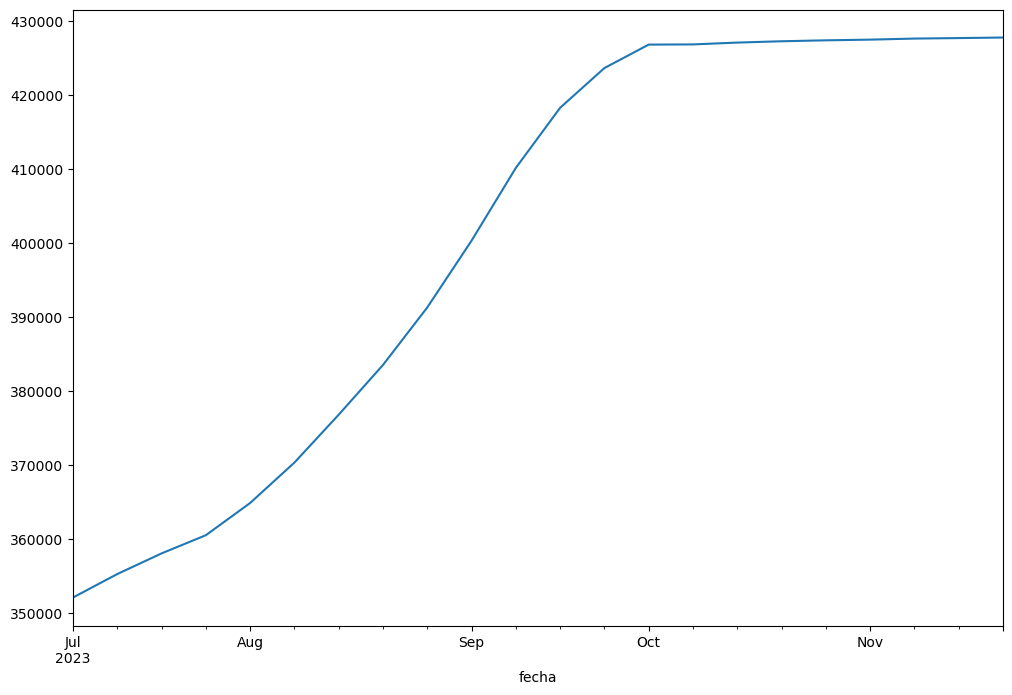

In [51]:
#totales.set_index("fecha", inplace=True)  # Asegúrate de que 'fecha' es el índice
totales

f1 = totales.loc['2023-07':'2023-12',:]
f1.positivos.plot(kind='line', stacked=True, figsize=(12,8))
#plt.loglog(f1.positivos)
# totales.fecha.between_time()totales.iloc[:,2:9].plot(kind='line', stacked=True, figsize=(12,8))
# totales.columns

In [21]:
totales.fecha.value_counts().sort_index()

fecha
2023-01-03    53
2023-01-10     1
2023-01-17     1
2023-01-24     1
2023-01-31     1
2023-02-07     1
2023-02-14     1
2023-02-21     1
2023-02-28     1
2023-03-07     1
2023-03-14     1
2023-03-21     1
2023-03-28     1
2023-04-04     1
2023-04-11     1
2023-04-18     1
2023-04-25     1
2023-05-02     1
2023-05-09     1
2023-05-17     1
2023-05-23     1
2023-05-30     1
2023-06-06     1
2023-06-13     1
2023-06-20     1
2023-06-27     1
2023-07-04     1
2023-07-11     1
2023-07-18     1
2023-07-25     1
2023-08-01     1
2023-08-08     1
2023-08-15     1
2023-08-22     1
2023-08-29     1
2023-09-05     1
2023-09-12     1
2023-09-19     1
2023-09-26     1
2023-10-03     1
2023-10-10     1
2023-10-17     1
2023-10-24     1
2023-10-31     1
2023-11-07     1
2023-11-14     1
2023-11-21     1
2023-11-28     1
2023-12-05     1
2023-12-12     1
2023-12-19     1
2023-12-26     1
Name: count, dtype: int64